# Notebook de NAS

Este notebook tiene el objetivo de recopilar todos los procesos necesarios para hacer NAS sobre una UNET, incluyendo la codificación, algoritmo de búsqueda y evaluación eficiente de la red.

In [7]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Concatenate, Input, Activation, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow as tf

from skimage.io import imshow, imread
from skimage import io, color, filters
from skimage.transform import resize
import cv2

import numpy as np
import matplotlib.pyplot as plt
import random
import os
import sys

#Unet

## Construcción de la red

In [8]:
def convolution_block(inputs, n_filters, kernel_size, activation):
    x = Conv2D(n_filters, (kernel_size, kernel_size), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(n_filters, (kernel_size, kernel_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    return x

def encoder_block(inputs, n_filters, kernel_size, activation):
    x = convolution_block(inputs, n_filters, kernel_size, activation)
    p = MaxPooling2D((2, 2))(x)

    return x, p

def decoder_block(inputs, skip, n_filters, kernel_size, activation):
    x = Conv2DTranspose(n_filters, (2,2), strides=2, padding='same')(inputs)
    x = Concatenate()([x, skip])
    x = convolution_block(x, n_filters, kernel_size, activation)
    return x

def get_unet(encode_filters, encode_kernel_sizes, encode_activations, decode_filters, decode_kernel_sizes, decode_activations, bridge_filters, bridge_kernel_size, bridge_activation, input_shape):
    inputs = Input(input_shape)

    # Builiding encoder layers
    encoders = []
    skips = []

    s,p = encoder_block(inputs, encode_filters.pop(0), encode_kernel_sizes.pop(0), encode_activations.pop(0))
    encoders.append(p)
    skips.append(s)

    for i, (filter, kernel_size, activation) in enumerate(zip(encode_filters, encode_kernel_sizes, encode_activations)):
        s, p = encoder_block(encoders[i], filter, kernel_size, activation)
        encoders.append(p)
        skips.append(s)

    # Bridge
    b = convolution_block(encoders[-1], bridge_filters, bridge_kernel_size, bridge_activation)

    # Building decoder layers
    decoders = []
    skips = skips[::-1]

    d = decoder_block(b, skips.pop(0), decode_filters.pop(0), decode_kernel_sizes.pop(0), decode_activations.pop(0))
    decoders.append(d)

    for i, (filter, kernel_size, activation) in enumerate(zip(decode_filters, decode_kernel_sizes, decode_activations)):
        d = decoder_block(decoders[i], skips[i], filter, kernel_size, activation)
        decoders.append(d)

    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(decoders[-1])
    model = Model(inputs, outputs)

    return model

## Random Unet

In [9]:
def random_unet(layers: int, max_depth: int, input_shape: int):
  encode_filters = []
  decode_filters = []
  encode_kernel_sizes = []
  decode_kernel_sizes = []
  encode_activations = []
  decode_activations = []

  for i in range(layers):
    # Filters
    encode_filters.append(np.random.randint(1, max_depth))
    decode_filters.append(np.random.randint(1, max_depth))

    # Kernel sizes
    encode_kernel_sizes.append(np.random.choice([3, 5]))
    decode_kernel_sizes.append(np.random.choice([3, 5]))

    # Activations
    encode_activations.append(np.random.choice(['relu', 'sigmoid']))
    decode_activations.append(np.random.choice(['relu', 'sigmoid']))

  # Bridge
  bridge_filters = np.random.randint(1, max_depth)
  bridge_kernel_size = np.random.choice([3, 5])
  bridge_activation = np.random.choice(['relu', 'sigmoid'])

  # Model
  model = get_unet(encode_filters, encode_kernel_sizes, encode_activations, decode_filters, decode_kernel_sizes, decode_activations, bridge_filters, bridge_kernel_size, bridge_activation, input_shape)
  return model

#Datos de entrenamiento

In [2]:
# Load images from drive
#%pip install dataset-tools
import dataset_tools as dtools
dtools.download(dataset = 'Car Segmentation', dst_dir = '/content/dataset')

Unpacking 'car-segmentation.tar': 100%|██████████| 429/429 [00:00<00:00, 452.94file/s] 


'/content/dataset\\car-segmentation'

# Configuración del dataset

## Data load

In [3]:
import numpy as np
from PIL import Image, ImageDraw
import os
import matplotlib.pyplot as plt
import json

In [4]:
def load_image(path: str, size: tuple = (512, 512)):
  """Load image from path and resize it to size

  Parameters
  ----------
  path : str
    Path to the image
  size : tuple, optional
    Size to resize the image, by default (512, 512)

  Returns
  -------
  img : np.array
  """
  # Open image
  img = Image.open(path)
  # Convert to RGB
  img = img.convert('RGB')
  # Resize Image
  img = img.resize(size)
  # Convert to numpy array
  img = np.array(img, dtype=np.float32)
  # Normalize
  img/=255.0

  return img

def load_mask(path: str, size: tuple = (512, 512)):
  """Load mask from json file and resize it to size

  Parameters
  ----------
  path : str
    Path to the json file
  size : tuple, optional
    Size to resize the mask, by default (512, 512)

  Returns
  -------
  mask : np.array
  """
  # Load JSON
  with open(path) as f:
    annotations = json.load(f)
  # Get shape
  height, width = annotations['size']['height'], annotations['size']['width']
  # Get car polygon
  polygon = [d for d in annotations['objects'] if d['geometryType'] == 'polygon' and d['classTitle'] == 'car']
  polygon = polygon[0] if polygon else None

  if polygon:
    # Get points
    points = [tuple(point) for point in polygon['points']['exterior']]
    # Draw mask
    mask = Image.new('1', (width, height), 0)
    draw = ImageDraw.Draw(mask)
    draw.polygon(points, outline=1, fill=1)
    # Resize
    mask = mask.resize(size)
    # Convert to numpy array
    mask = np.array(mask, dtype=np.uint8)

    return mask

  else:
    return None

def load_dataset(images_path, annotations_path, size, n_samples):
  images = []
  masks = []
  images_names = os.listdir(images_path)
  for img in images_names:
    image_path = os.path.join(images_path, img)
    mask_path = os.path.join(annotations_path, f'{img}.json')
    image = load_image(image_path, size)
    mask = load_mask(mask_path, size)

    if mask is not None:
      images.append(image)
      masks.append(mask)

    if len(images) == n_samples:
      break

  return np.array(images), np.array(masks)

In [5]:
images_path = '/content/dataset/car-segmentation/ds/img'
annotations_path = '/content/dataset/car-segmentation/ds/ann'
size = (256, 256)
n_samples = 1000
images, masks = load_dataset(images_path, annotations_path, size, n_samples)

c:\Users\Jafet\anaconda3\envs\TT\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#Prueba de concepto estimador de covarianza de entrada y salida


In [10]:
model_good = tf.keras.models.load_model('/content/unet_untrained_10.h5')
model_bad = tf.keras.models.load_model('/content/unet_untrained_5.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/unet_untrained_10.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
def get_tapes(model, X):
  tapes = []
  for x in X:
    input = tf.expand_dims(x, axis=0)
    input = tf.convert_to_tensor(input, dtype=tf.float32)
    with tf.GradientTape() as tape:
      tape.watch(input)
      output = model(input)
    gradient = tape.gradient(output, input)
    tapes.append(gradient)
  return tapes

In [ ]:
def get_covarianze(x, y):
  # Asegúrate de que ambos tensores tienen la misma forma
  assert x.shape == y.shape

  #Aplanar x y y
  x = tf.reshape(x, [-1])
  y = tf.reshape(y, [-1])

  # Paso 1: Restar la media de cada tensor
  x_mean = tf.reduce_mean(x)
  y_mean = tf.reduce_mean(y)
  x_centered = x - x_mean
  y_centered = y - y_mean

  # Paso 2: Calcular la covarianza
  cov = tf.reduce_mean(x_centered * y_centered)

  return cov

In [ ]:
def get_covarianze_mean(tapes):
  covarianze_mean = 0
  for i in range(len(tapes)):
    for j in range(len(tapes)):
      covarianze = get_covarianze(tapes[i], tapes[j])
      covarianze_mean += covarianze
  return covarianze_mean

## Model Good

In [ ]:
tapes = get_tapes(model_good, images[:4])
value = get_covarianze_mean(tapes)
float(value)

0.0013934263261035085

In [ ]:
tapes = get_tapes(model_good, images[12:16])
value = get_covarianze_mean(tapes)
float(value)

0.0013396668946370482

In [ ]:
tapes = get_tapes(model_good, images[22:28])
value = get_covarianze_mean(tapes)
float(value)

0.0025765441823750734

## Prueba con los 20 modelos

## Obtener los accuracys

In [ ]:
import pandas as pd
# Cargar el csv de accuracys
df = pd.read_csv('/content/log.csv')

# Drop where trained is 0
df = df[df['trained'] == 1]

# Obtener lista de accs
df = df['accuracy']
accs = df.to_list()

## Obtener los scores

In [ ]:
models = []
for i in range(20):
  model = tf.keras.models.load_model(f'/content/models/unet_untrained_{i}.h5')
  models.append(model)

WARN:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
WARN:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
WARN:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
WARN:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
WARN:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
WARN:absl:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
WARN:absl:Compiled the loaded mode

In [ ]:
scores = []
for model in models:
  tapes = get_tapes(model, images[:2])
  value = get_covarianze_mean(tapes)
  scores.append(float(value))

In [ ]:
accs, scores

([0.3444022238254547,
  0.3486860394477844,
  0.4952027201652527,
  0.5034683346748352,
  0.3447531759738922,
  0.4766799509525299,
  0.3453273475170135,
  0.4368626773357391,
  0.3598558306694031,
  0.5401511788368225,
  0.7393085360527039,
  0.6561449766159058,
  0.3569009602069855,
  0.3442822694778442,
  0.3441009521484375,
  0.3460217714309692,
  0.607365071773529,
  0.515257716178894,
  0.3712605237960815,
  0.5486893653869629],
 [8.749029802856967e-06,
  2.0602506992872804e-05,
  1.8284258658241015e-06,
  0.00036648171953856945,
  9.435343599761836e-06,
  8.381873612961499e-07,
  0.0001889820850919932,
  5.7631321936924e-09,
  1.0324062316158233e-07,
  0.00041841212077997625,
  0.0003486697096377611,
  3.904922607489425e-08,
  6.603204838029342e-06,
  0.00025089073460549116,
  9.546182582198526e-07,
  2.7711770655969303e-08,
  2.141893901352887e-06,
  3.381132273716503e-06,
  2.2420117602450773e-06,
  9.324185157311149e-06])

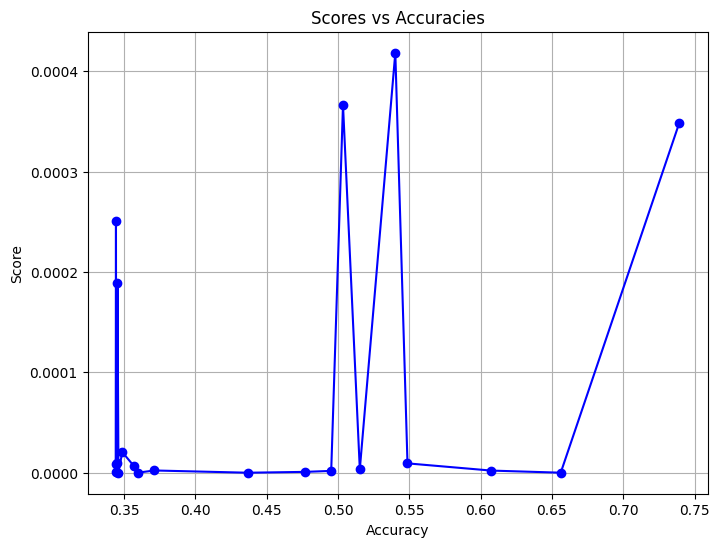

In [ ]:
# Combinar las listas en pares (accuracy, score)
paired_data = list(zip(accs, scores))

# Ordenar los pares por accuracys
paired_data.sort()

# Separar las listas nuevamente, ya ordenadas
accs, scores = zip(*paired_data)


plt.figure(figsize=(8, 6))
plt.plot(accs, scores, marker='o', linestyle='-', color='b')

# Etiquetas de los ejes
plt.xlabel('Accuracy')
plt.ylabel('Score')

# Título de la gráfica
plt.title('Scores vs Accuracies')

# Mostrar la gráfica
plt.grid(True)
plt.show()

# Prueba de concepto correlación entrada salida

In [ ]:
def get_correlation(x, y):
  # Asegúrate de que ambos tensores tienen la misma forma
  assert x.shape == y.shape
  x_flat = tf.reshape(x, [-1])
  y_flat = tf.reshape(y, [-1])
  x_centered = x_flat - tf.reduce_mean(x_flat)
  y_centered = y_flat - tf.reduce_mean(y_flat)
  cov = tf.reduce_mean(x_centered * y_centered)
  std_x = tf.math.reduce_std(x_flat)
  std_y = tf.math.reduce_std(y_flat)
  correlation = cov / (std_x * std_y)
  return correlation

In [ ]:
def get_correlation_mean(tapes):
  correlation_mean = 0
  for i in range(len(tapes)):
    for j in range(len(tapes)):
      correlation = get_correlation(tapes[i], tapes[j])
      correlation_mean += correlation
  return correlation_mean

## Prueba

In [ ]:
# Cargar el csv de accuracys
df = pd.read_csv('/content/log.csv')

# Drop where trained is 0
df = df[df['trained'] == 1]

# Obtener lista de accs
df = df['accuracy']
accs = df.to_list()

In [ ]:
scores = []
for model in models:
  tapes = get_tapes(model, images[10:12])
  value = get_correlation_mean(tapes)
  scores.append(float(value))

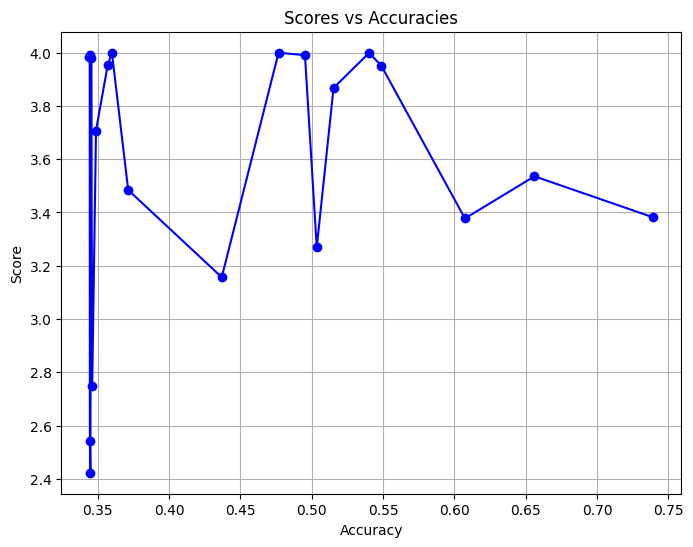

In [ ]:
# Combinar las listas en pares (accuracy, score)
paired_data = list(zip(accs, scores))

# Ordenar los pares por accuracys
paired_data.sort()

# Separar las listas nuevamente, ya ordenadas
accs, scores = zip(*paired_data)


plt.figure(figsize=(8, 6))
plt.plot(accs, scores, marker='o', linestyle='-', color='b')

# Etiquetas de los ejes
plt.xlabel('Accuracy')
plt.ylabel('Score')

# Título de la gráfica
plt.title('Scores vs Accuracies')

# Mostrar la gráfica
plt.grid(True)
plt.show()

# Prueba con la variación de accuracies

## Covariance

In [ ]:
import pandas as pd
# Cargar el csv de accuracys
df = pd.read_csv('/content/log.csv')

df_untrained = df[df['trained'] == 1]
df_trained = df[df['trained'] == 0]

# Obtener lista de accs
df = df_untrained['accuracy']
accs_untrained = df.to_numpy()

df = df_trained['accuracy']
accs_trained = df.to_numpy()

# Obtener la variación de accs
accs_variation = accs_untrained - accs_trained
accs_variation = accs_variation.tolist()

In [ ]:
# Get scores covariance
scores = []
for model in models:
  tapes = get_tapes(model, images[2:4])
  value = get_covarianze_mean(tapes)
  scores.append(float(value))

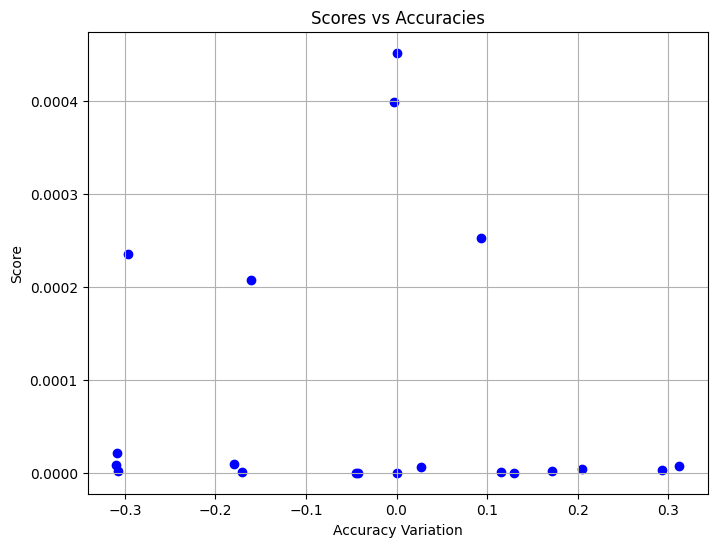

In [ ]:
# Combinar las listas en pares (accuracy, score)
paired_data = list(zip(accs_variation, scores))

# Ordenar los pares por accuracys
paired_data.sort()

# Separar las listas nuevamente, ya ordenadas
accs_variation, scores = zip(*paired_data)


plt.figure(figsize=(8, 6))
plt.scatter(accs_variation, scores, marker='o', linestyle='-', color='b')

# Etiquetas de los ejes
plt.xlabel('Accuracy Variation')
plt.ylabel('Score')

# Título de la gráfica
plt.title('Scores vs Accuracies')

# Mostrar la gráfica
plt.grid(True)
plt.show()

## Correlación

In [ ]:
import pandas as pd
# Cargar el csv de accuracys
df = pd.read_csv('/content/log.csv')

df_untrained = df[df['trained'] == 1]
df_trained = df[df['trained'] == 0]

# Obtener lista de accs
df = df_untrained['accuracy']
accs_untrained = df.to_numpy()

df = df_trained['accuracy']
accs_trained = df.to_numpy()

# Obtener la variación de accs
accs_variation = accs_untrained - accs_trained
accs_variation = accs_variation.tolist()

In [ ]:
# Get scores covariance
scores = []
for model in models:
  tapes = get_tapes(model, images[0:2])
  value = get_correlation_mean(tapes)
  scores.append(float(value))

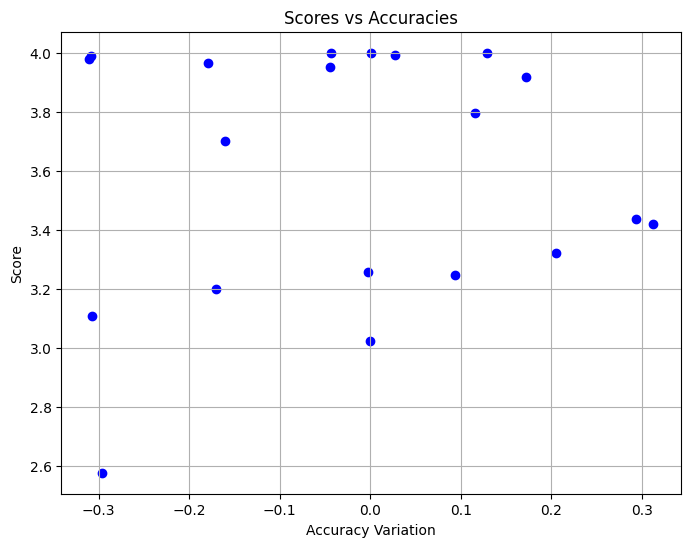

In [ ]:
# Combinar las listas en pares (accuracy, score)
paired_data = list(zip(accs_variation, scores))

# Ordenar los pares por accuracys
paired_data.sort()

# Separar las listas nuevamente, ya ordenadas
accs_variation, scores = zip(*paired_data)


plt.figure(figsize=(8, 6))
plt.scatter(accs_variation, scores, marker='o', linestyle='-', color='b')

# Etiquetas de los ejes
plt.xlabel('Accuracy Variation')
plt.ylabel('Score')

# Título de la gráfica
plt.title('Scores vs Accuracies')

# Mostrar la gráfica
plt.grid(True)
plt.show()

# SYNFLOW

In [ ]:
def get_synflow_tapes(model):
  # Get the inpút shape of the model
  input_shape = model.layers[0].input_shape[1:]

  # Generate a input tensor of 1s
  input = tf.ones(shape=(1, *input_shape))

  # Set the model weights to 1
  for layer in model.layers:
    layer.set_weights([np.ones(shape=input_shape)])

  # Get the gradient Tape using the output respecto a los pesos
  with tf.GradientTape() as tape:
    tape.watch(model.layers[0].weights[0])
    output = model(input)
  gradient = tape.gradient(output, model.layers[0].weights[0])

  #sum the gradient tape
  synflow_tape = tf.reduce_sum(gradient, axis=0)

  return synflow_tape


SyntaxError: invalid syntax (<ipython-input-2-987b2ecbb922>, line 6)